In [1]:
%load_ext autoreload

In [66]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil
import sys
from skimage.filters import gabor_kernel

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

image_dim = (224//5)

cuda:0


In [68]:
def scale_rgb(x):
    return (x - x.min()) / (x.max() - x.min())

In [69]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224//5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1000


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [70]:
image_dim = (224//5)
frequency = 0.006
theta = 0.0
kernel = gabor_kernel(frequency, theta=theta)

input_height, input_width = kernel.shape

kernel = gabor_kernel(frequency, theta=theta)

# Calculate cropping boundaries
crop_top = (input_height - image_dim) // 2
crop_bottom = crop_top + image_dim
crop_left = (input_width - image_dim) // 2
crop_right = crop_left + image_dim

# Perform the crop
weights = np.real(kernel)[crop_top:crop_bottom, crop_left:crop_right]

# scale weights
weights = scale_rgb(weights)

# repeat the weights for each channel and flatten
weights = torch.tensor(weights, dtype=torch.float32)
flat_weights = np.repeat(weights.unsqueeze(0), 3, axis=0).view(1, -1)

In [71]:
# pass images through toy_network to get activations
class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim*image_dim*3, 1)
        self.fc1.weight = torch.nn.Parameter(flat_weights)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

toy_net = Toynetwork().to(device)

In [72]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        # activation[name] = output.numpy()
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [73]:
inputs_list = []
# outputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['fc1'])

        inputs_list.append(inputs.detach().cpu().numpy())
        # outputs_list.append(output.detach().cpu().numpy())

    del inputs
    del output

# detach the hooks
hook.remove()

100%|███████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


In [74]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])

samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, ((224//5))*((224//5))*3))
responses = np.zeros((act_length, 1))
# outputs = np.zeros((act_length, 1))
x_dim=((224//5))*((224//5))*3
y_dim=1

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, 0] = act_list[batch][image, 0]
        # outputs[batch*len(act_list[0])+image, 0] = outputs_list[batch][image, 0]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image]

# del act_list, inputs_list, outputs_list
del act_list, inputs_list

In [75]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 1, bias=False)
        self.fc1y = nn.Linear(y_dim, 1, bias=False)
        self.fc2 = nn.Linear(2, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [76]:
lam = 0.005
lam_str = str(lam)

In [77]:
mine = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
    device=device).to(device)
mi, loss_list = mine.optimize(torch.tensor(images_flat, dtype=torch.float32), torch.tensor(responses, dtype=torch.float32), 250, batch_size, lam, "1")

  0%|          | 0/250 [00:00<?, ?it/s]

Final MI: 1.6496126651763916


In [78]:
torch.save(mine.T, "minegaborcheckpt" + lam_str + ".pth")
np.save("migaborcheckpt" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("lossgaborcheckpt" + lam_str + ".npy", torch.stack(loss_list).detach().cpu().numpy())

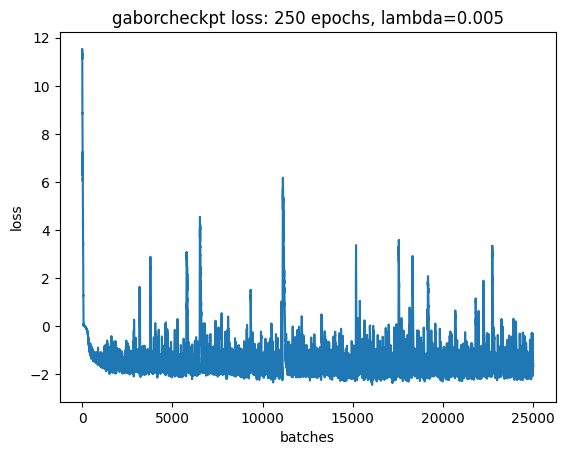

In [79]:
plt.figure()
plt.plot(torch.stack(loss_list).detach().cpu().numpy())
plt.title("gaborcheckpt loss: 250 epochs, lambda=" + lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
plt.savefig("lossgaborcheckpt" + lam_str+".pdf")

In [80]:
Tweights = mine.T.fc1x.weight.detach().cpu().numpy()[0]

unflat_Tweights = np.reshape(Tweights, (3, (224//5), (224//5)))

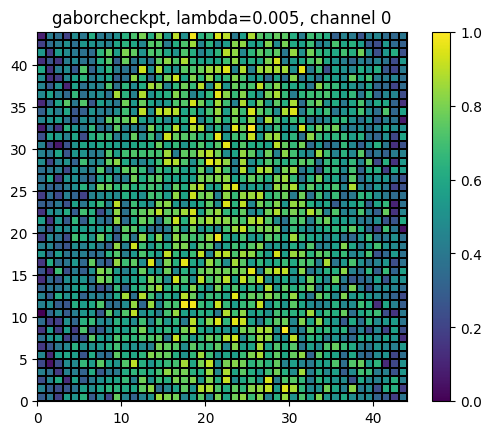

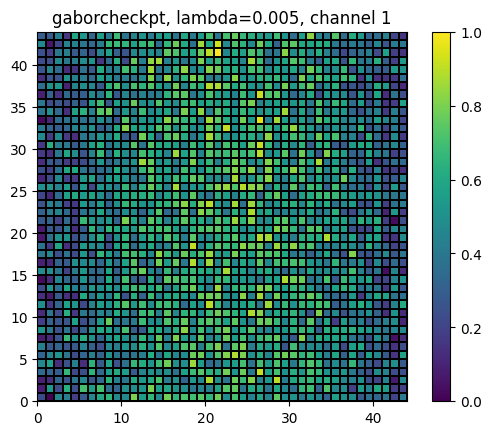

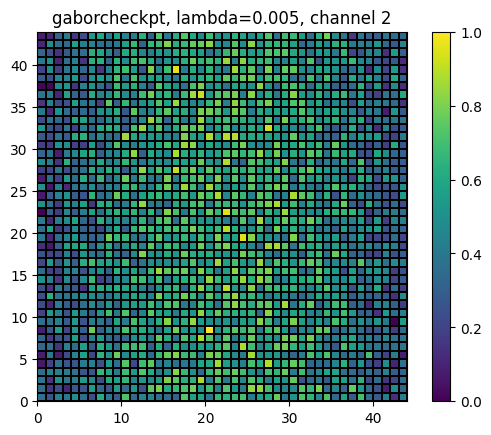

In [81]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_Tweights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"gaborcheckpt, lambda={lam_str}, channel {i}")
    plt.savefig(f"Tweightsc{i}{lam_str}gaborcheckpt.pdf")

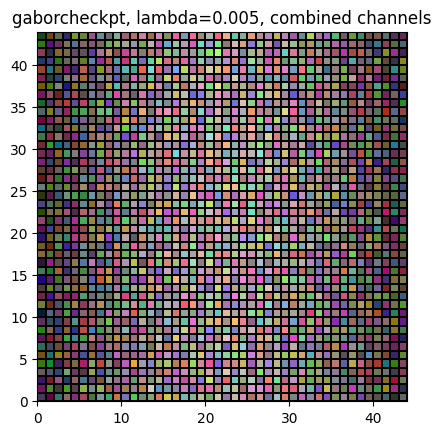

In [82]:
plt.figure()
plt.pcolormesh(
    np.transpose(np.array(list(map(scale_rgb, unflat_Tweights))), (1, 2, 0)),
    edgecolors="k",
    linewidth=0.005,
)
plt.title(f"gaborcheckpt, lambda={lam_str}, combined channels")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("Tweightscomb" + lam_str + "gaborcheckpt.pdf")

In [83]:
avg_weights = np.load("avg_weights_1.npy")
best_model = torch.load("mine_best_1.pth")
best_weights = best_model.fc1x.weight.detach().cpu().numpy()[0]

In [84]:
unflat_avg_weights = np.reshape(avg_weights, (3, (224//5), (224//5)))
unflat_best_weights = np.reshape(best_weights, (3, (224//5), (224//5)))

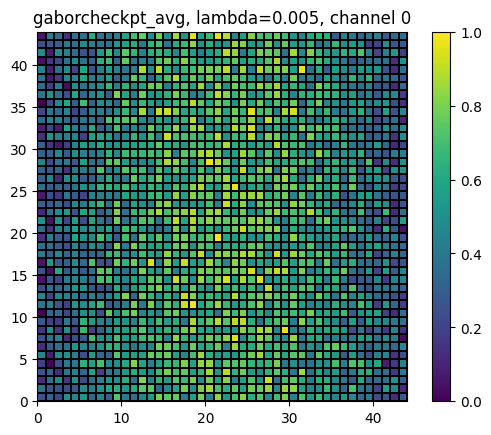

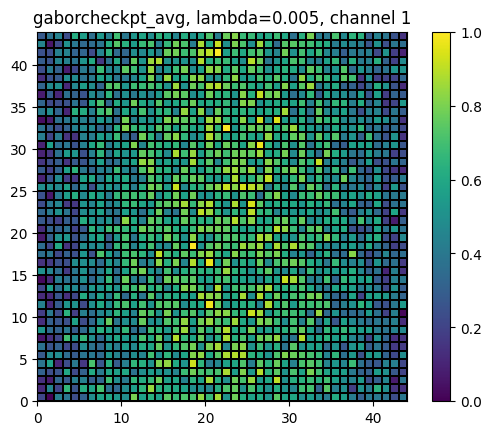

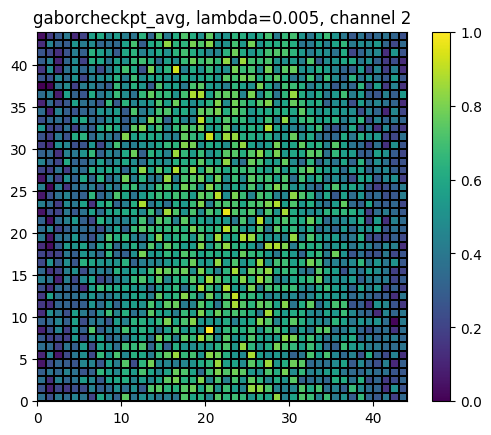

In [85]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_avg_weights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"gaborcheckpt_avg, lambda={lam_str}, channel {i}")
    plt.savefig(f"Tweightsc{i}{lam_str}gaborcheckpt_avg.pdf")

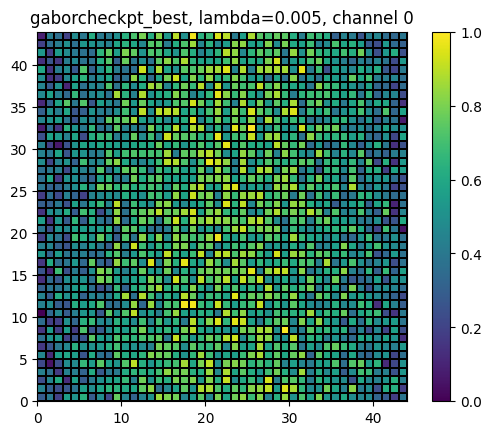

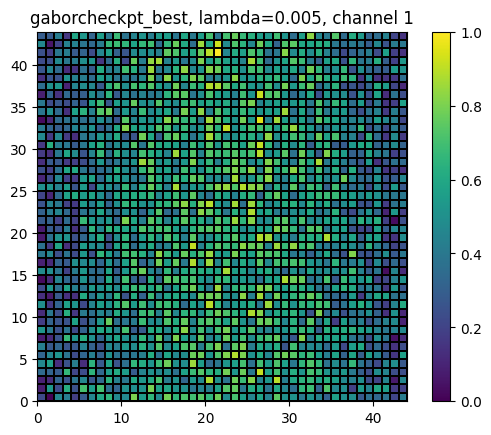

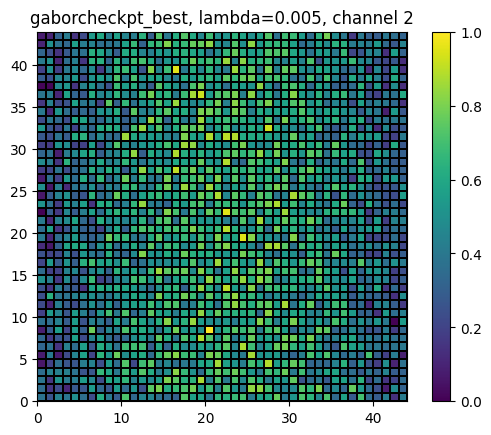

In [86]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_best_weights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"gaborcheckpt_best, lambda={lam_str}, channel {i}")
    plt.savefig(f"Tweightsc{i}{lam_str}gaborcheckpt_best.pdf")

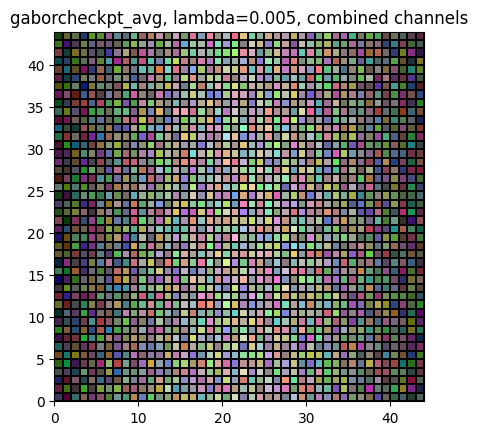

In [87]:
plt.figure()
plt.pcolormesh(
    np.transpose(np.array(list(map(scale_rgb, unflat_avg_weights))), (1, 2, 0)),
    edgecolors="k",
    linewidth=0.005,
)
plt.title(f"gaborcheckpt_avg, lambda={lam_str}, combined channels")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("Tweightscomb" + lam_str + "gaborcheckpt_avg.pdf")

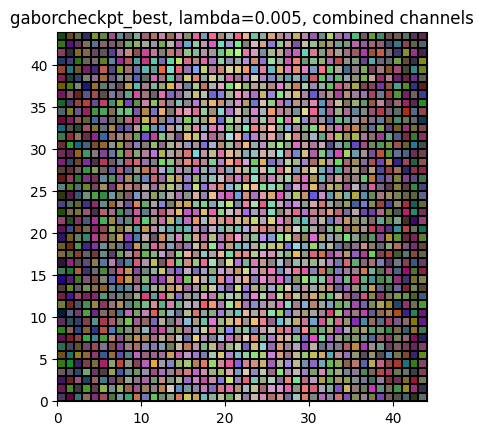

In [88]:
plt.figure()
plt.pcolormesh(
    np.transpose(np.array(list(map(scale_rgb, unflat_best_weights))), (1, 2, 0)),
    edgecolors="k",
    linewidth=0.005,
)
plt.title(f"gaborcheckpt_best, lambda={lam_str}, combined channels")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("Tweightscomb" + lam_str + "gaborcheckpt_best.pdf")

In [34]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 2, bias=False)
        self.fc1y = nn.Linear(y_dim, 2, bias=False)
        self.fc2 = nn.Linear(4, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [35]:
mine2 = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
    device=device).to(device)
mi2, loss_list2 = mine2.optimize(torch.tensor(images_flat, dtype=torch.float32), torch.tensor(responses, dtype=torch.float32), 150, batch_size, lam, "2")

  0%|          | 0/150 [00:00<?, ?it/s]

Final MI: 2.415421962738037


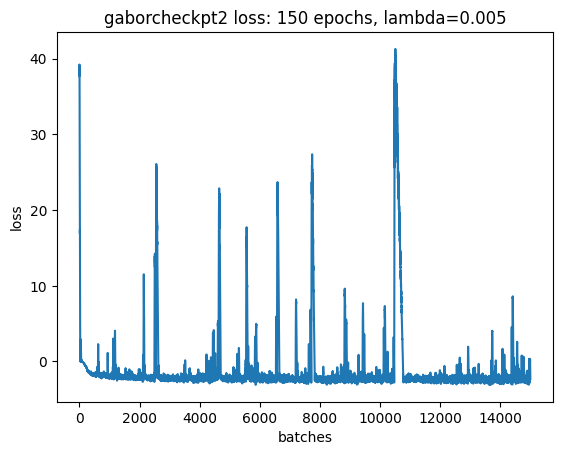

In [38]:
torch.save(mine2.T, "minegaborcheckpt2" + lam_str + ".pth")
np.save("migaborcheckpt2" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("lossgaborcheckpt2" + lam_str + ".npy", torch.stack(loss_list2).detach().cpu().numpy())

plt.figure()
plt.plot(torch.stack(loss_list2).detach().cpu().numpy())
plt.title("gaborcheckpt2 loss: 150 epochs, lambda=" + lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
plt.savefig("lossgaborcheckpt2" + lam_str+".pdf")

In [62]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 3, bias=False)
        self.fc1y = nn.Linear(y_dim, 3, bias=False)
        self.fc2 = nn.Linear(6, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [64]:
mine3 = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
    device=device).to(device)
mi3, loss_list3 = mine3.optimize(torch.tensor(images_flat, dtype=torch.float32), torch.tensor(responses, dtype=torch.float32), 250, batch_size, lam, "#")

  0%|          | 0/250 [00:00<?, ?it/s]

Final MI: 4.6703782081604


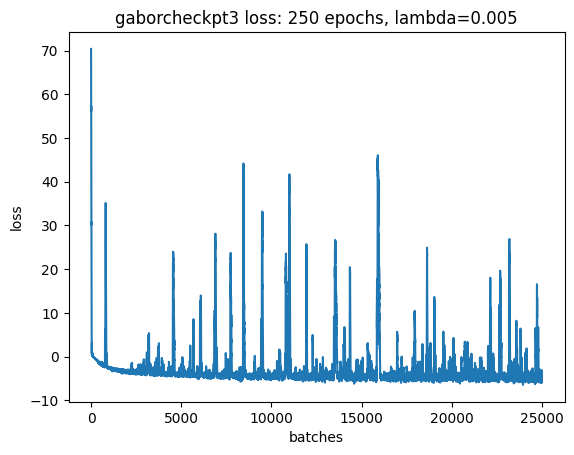

In [65]:
torch.save(mine3.T, "minegaborcheckpt3" + lam_str + ".pth")
np.save("migaborcheckpt3" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("lossgaborcheckpt3" + lam_str + ".npy", torch.stack(loss_list3).detach().cpu().numpy())

plt.figure()
plt.plot(torch.stack(loss_list3).detach().cpu().numpy())
plt.title("gaborcheckpt3 loss: 250 epochs, lambda=" + lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
plt.savefig("lossgaborcheckpt3" + lam_str+".pdf")

In [89]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 4, bias=False)
        self.fc1y = nn.Linear(y_dim, 4, bias=False)
        self.fc2 = nn.Linear(8, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [90]:
mine4 = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
    device=device).to(device)
mi4, loss_list4 = mine4.optimize(torch.tensor(images_flat, dtype=torch.float32), torch.tensor(responses, dtype=torch.float32), 150, batch_size, lam, "4")

  0%|          | 0/150 [00:00<?, ?it/s]

Final MI: 5.108710765838623


In [91]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 5, bias=False)
        self.fc1y = nn.Linear(y_dim, 5, bias=False)
        self.fc2 = nn.Linear(10, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [92]:
mine5 = Mine(
    T=Image_network(x_dim, y_dim),
    loss="mine",  # mine_biased, fdiv
    device=device).to(device)
mi5, loss_list5 = mine5.optimize(torch.tensor(images_flat, dtype=torch.float32), torch.tensor(responses, dtype=torch.float32), 150, batch_size, lam, "5")

  0%|          | 0/150 [00:00<?, ?it/s]

Final MI: 5.116544723510742
